This is the first in a series of posts that I plan on writing as I learn how to apply Bayesian methods to different topics/problems that I find interesting. In this post I go over how to use the Bayesian bootstrap to get measure of uncertainty for an NFL quarterback's (QB) yards per pass attempt (YPA).


## What is the Bayesian Bootstrap and how do we compute it?

Bootstrapping is a resampling technique that allows us to calculate the uncertainty for a given statistic of interest (e.g. mean, median, etc.).  In the classical bootstrap we construct these measures of uncertainty by first creating multiple datasets, called bootstrap samples, by sampling with replacement from the original data. Then for each of these newly generated samples, we calculate the statistic of interest and end up with an approximation of its distribution.

Here is an example of the classical bootstrap being used to construct an interval around a regression line:

In [1]:
from IPython.display import Video
Video('https://www.stat.auckland.ac.nz/~wild/BootAnim/movies/bootstrap5-1.mp4')

In the classical bootstrap, sampling with replacement can be seen as [applying weights to our observations, based on the (normalized) counts we draw from a multinomial distribution](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/#its-the-bayesian-bootstrap-but-with-discrete-weights).  In the Bayesian bootstrap, instead of applying weights from a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) we apply weights from a uniform (flat) [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). ([Here's](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution-as-a-probability-distribution-over-the-k-%E2%88%92-1-dimensional-probability-simplex) an intuitive explanation of the Dirichlet distribution for those who don't know what it is). To create Bayesian bootstrap samples, we repeat the following procedure as many times as we'd like (the more times we repeat it the better):

1. Draw weights from a uniform Dirichlet distribution with the same dimension as the number of observations in the data.
    - **NOTE:** Here the uniform Dirichlet distribution acts as an uninformative prior.
2. If possible, calculate the statistic using the weights from the Dirichlet distribution.
3. Otherwise, if the statistic doesn’t directly use weights in its calculation do the following:
    1. Resample the data according to the weights drawn from the Dirichlet distribution.
        - **NOTE:** In this step we create as large of a sample as possible. It should as large as the original dataset.
    2. Use the resampled data to calculate the statistic.

The final distribution created by the Bayesian bootstrap is a [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) of the statistic of interest.

To get a better sense of the above procedure let’s code up our own Bayesian bootstrap function.

In [2]:
import numpy as np

def bayes_boot(X, statistic, n_samples1=1000, n_samples2=1000, weight_kwd=None,
               *args, **kwargs):
        
    # draw our weights from the uniform dirichlet distribution
    # [1]*len(X) is the dimension of the distribution
    # n_samples1 represents the number of bootstrap replications to perform
    # from the bayesian perspective think of it as the number of draws from the
    # posterior distribution
    # in terms of the classical bootstrap this is the number times the data is 
    # resampled
    weights = np.random.dirichlet([1]*len(X), n_samples1)
    
    # if the statistic function accepts weights, use them to calculate the 
    # bayesian bootstrap samples
    if weight_kwd is not None:
        samples = [statistic(X, *args, **{weight_kwd: w}, **kwargs) for w in weights]
    
    # otherwise we have to do a weighted resampling of the data, based on
    # the weights we drew from the dirichlet distribution
    else:
        samples = []
        for w in weights:
            # resample the indexes using the dirchlet weights
            # the greater n_sample2 is, the better
            sample_idx = np.random.choice(range(len(X)), p=w, size=n_samples2)
            X_resample = X[sample_idx]
            # calculate the statistic on the resampled data and append it
            # to our samples list
            samples.append(statistic(X, *args, **kwargs))

    return np.array(samples)

## Applying the Bayesian Boostrap to the NFL
Now that we have some knowledge of how the Bayesian bootstrap works, let’s use it to compare Drew Brees’ and Deshaun Watson’s mean YPA from last season.  Even though we made our own Bayesian bootstrap function, going forward we will use the [bayesian_bootstrap](https://github.com/lmc2179/bayesian_bootstrap) package for our analysis.

First let's import the remaining packages we will use.

In [3]:
# import the rest of the packages we will use
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import bayesian_bootstrap.bootstrap as bb
from scipy import stats
from astropy.utils import NumpyRNGContext

In [4]:
# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

Then let's set up our data. The play by play data comes from [Ron Yurko's](https://twitter.com/Stat_Ron) awesome [nflscrapR-data github repository](https://github.com/ryurko/nflscrapR-data).

In [5]:
# Read in and set up our data. 
pbp_df = pd.read_csv('data/pbp_2017.csv', low_memory=False)
rosters_df = pd.read_csv('data/team_2017_rosters.csv')

# replace . with _
pbp_df.columns = pbp_df.columns.str.replace('.', '_')

# keep all qb pass attempt
# first we keep the plays where a pass occured
# then we get the passer's position (along with their full name and GSIS_ID)
# in order to filter out all non-QB pass attempts
qb_pass_df = (pbp_df.query('PassAttempt == 1')
                    .merge(rosters_df[['GSIS_ID', 'Player', 'Pos']], how='left', 
                           left_on='Passer_ID', right_on='GSIS_ID')
                    .query('Pos == "QB"'))

# some plays are labeled as both a sack and a pass attempts, they should be
# one or the other
# For the 2017 pbp data I found 17 instances where this mislabeling occurs
# I manually checked the description in another notebook, 
# they tend to be plays that were challenged and reversed
# here I correct the issue
sack_and_pass_mask = (qb_pass_df.Sack==1) & (qb_pass_df.PassAttempt==1)
corrected_sack = np.array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1])
corrected_pass = 1 - corrected_sack
qb_pass_df.loc[sack_and_pass_mask, 'Sack'] = corrected_sack
qb_pass_df.loc[sack_and_pass_mask, 'PassAttempt'] = corrected_pass

In [6]:
brees_df = qb_pass_df.loc[qb_pass_df.Player == 'Drew Brees']
watson_df = qb_pass_df.loc[qb_pass_df.Player == 'Deshaun Watson']

In [7]:
# make sure only 1 player has the name Dree Brees
brees_df.GSIS_ID.nunique()

1

In [8]:
# check Watson too
watson_df.GSIS_ID.nunique()

1

Now that we have the data set up, let's calculate each player's YPA for the 2017 season.

In [9]:
brees_ypa = brees_df.Yards_Gained.sum() / brees_df.Yards_Gained.size
watson_ypa = watson_df.Yards_Gained.sum() / watson_df.Yards_Gained.size
brees_text = "Brees threw {} total yards on {} pass attempts, averaging {:.2F} yards per attempt"
player_text = "{} threw {} total yards on {} pass attempts, averaging {:.2F} yards per attempt"

print(player_text.format('Brees', brees_df.Yards_Gained.sum(),
                         brees_df.Yards_Gained.size,  brees_ypa))
print(player_text.format('Watson', watson_df.Yards_Gained.sum(),
                         watson_df.Yards_Gained.size, watson_ypa))

Brees threw 4377 total yards on 534 pass attempts, averaging 8.20 yards per attempt
Watson threw 1699 total yards on 202 pass attempts, averaging 8.41 yards per attempt


To construct our Bayesian bootstrap samples for each QB, we pass the yards gained on each of their pass attempts to `bayesian_bootstrap`'s `mean` function and set the number of replications we want.

In [10]:
# for reproducibility, set the seed within this context
with NumpyRNGContext(42):
    brees_bootstrap = bb.mean(brees_df.Yards_Gained, n_replications=10000)
    watson_bootstrap = bb.mean(watson_df.Yards_Gained, n_replications=10000)

`mean` returns us a `list` with the mean for each bootstrapped sample.  This `list` is the posterior distribution over the probable mean values of the data we are interested in.

In [11]:
# the mean YPA for the first 5 bootstrapped samples
brees_bootstrap[:5]

[8.843777687854217,
 8.359018541846776,
 8.23741936451607,
 7.96389640889533,
 7.853083565824609]

In [12]:
# there are a total of 10000 means, 1 for each replication
len(brees_bootstrap)

10000

It's pretty straightforward to plot the posterior with `seaborn`'s `distplot` function.

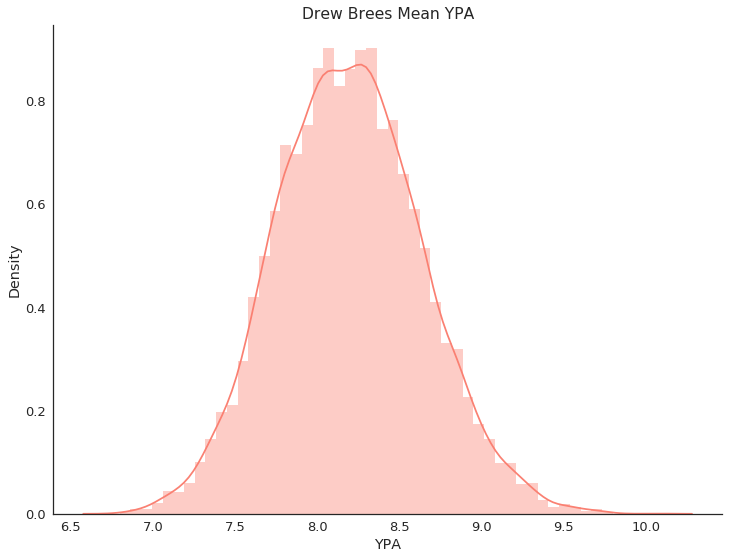

In [13]:
ax = sns.distplot(brees_bootstrap, color='salmon')
ax.set(xlabel='YPA', ylabel='Density', title='Drew Brees Mean YPA')
sns.despine();

We can also construct a credible interval. `bayesian_bootstrap` provides two methods to do that, the `central_credible_interval` and the `highest_density_interval` functions. When constructing intervals for unimodal (i.e. it has one peak), symmetric distribution, both methods should give you similar intervals. But if the distribution is multimodal (i.e. it has multiple peaks representing well separated modes), the `central_credible_interval` function will return a single interval while the the `highest_density_interval` will return multiple disjointed intervals centered around the modes of the distribution. A good discussion on these two methods of constructing credible intervals can be found [here](https://stats.stackexchange.com/questions/240749/how-to-find-95-credible-interval) and [here](https://stats.stackexchange.com/questions/24588/quantile-intervals-vs-highest-posterior-density-intervals). Here we will use the `highest_density_interval` function to calculate our credible intervals.

In [14]:
# Calculate a 95% HDI
brees_ci_low, brees_ci_hi = bb.highest_density_interval(brees_bootstrap)
print('low ci:', brees_ci_low, '\nhigh ci:', brees_ci_hi)

low ci: 7.328395018390543 
high ci: 9.040847997805901


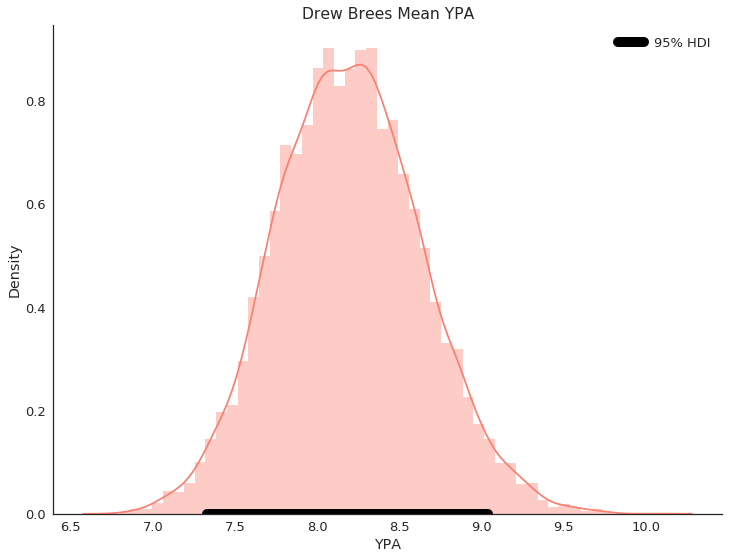

In [15]:
ax = sns.distplot(brees_bootstrap, color='salmon')
ax.plot([brees_ci_low, brees_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='YPA', ylabel='Density', title='Drew Brees Mean YPA')
sns.despine()
plt.legend();

Brees' 95% HDI is between 7.33 and 9.04 YPA, which means that according to our model (you can think  of the Bayesian bootstrap as [poor man's model](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/#some-final-thoughts)) and the data we've observed (Brees' passes), there is a 95% chance that Brees' mean YPA is between 7.33 YPA and 9.04 YPA. 

Now let's also plot Watson's posterior distribution and compare the distributions for both QBs.

In [16]:
# Calculate a 95% HDI
watson_ci_low, watson_ci_hi = bb.highest_density_interval(watson_bootstrap)
print('low ci:', watson_ci_low, '\nhigh ci:', watson_ci_hi)

low ci: 6.897497857396077 
high ci: 9.98398392946718


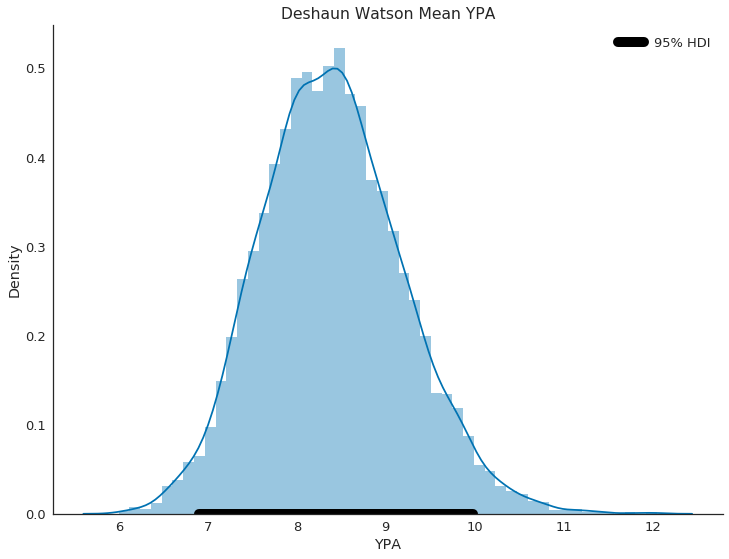

In [17]:
ax = sns.distplot(watson_bootstrap)
ax.plot([watson_ci_low, watson_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='YPA', ylabel='Density', title='Deshaun Watson Mean YPA')
sns.despine()
plt.legend();

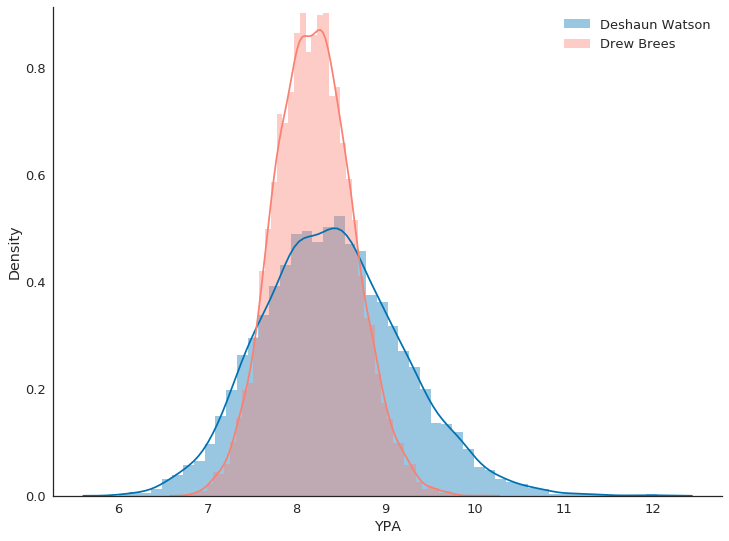

In [18]:
ax = sns.distplot(watson_bootstrap, label='Deshaun Watson')
ax = sns.distplot(brees_bootstrap, label='Drew Brees', ax=ax, color='salmon')
ax.set(xlabel='YPA', ylabel='Density')
sns.despine()
plt.legend();

Watson's posterior distribution is shorter and wider than Brees', which indicates that there is more uncertainty with respect to Watson's mean YPA. 

We can also measure the uncertainty in the difference between the player's YPA by subtracting their posteriors.

In [19]:
# calculate the posterior for the difference between Watson's and Brees YPA
ypa_diff = np.array(watson_bootstrap) - np.array(brees_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [20]:
# the mean of the posterior
ypa_diff.mean()

0.20419893500495132

In [21]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)

low ci: -1.515096340562379 
high ci: 2.0270425574753084


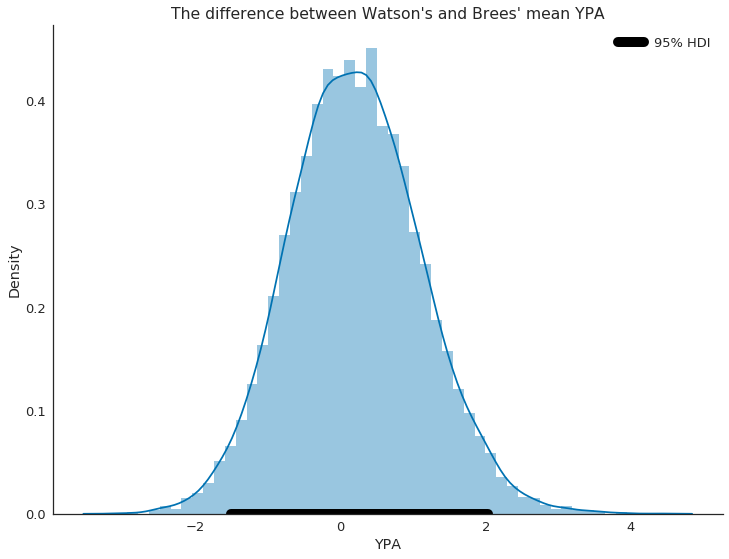

In [22]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='YPA', ylabel='Density', 
       title='The difference between Watson\'s and Brees\' mean YPA')
sns.despine()
plt.legend();

So the mean of the posterior is about 0.2 and the 95% HDI is pretty wide, ranging from -1.5 to about 2, indicating to us that we can't really be certain that the two player's mean YPA were that different last season. 

We can actually calculate the probability that Watson's mean YPA was greater than Brees' mean YPA by measuring the proportion of values greater than 0 in the above distribution.

In [23]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.5782

So it looks like about 58% of the distribution is greater than 0, which doesn't give us much confidence that Watson's mean YPA was greater than Brees'.

## Comparing multiple players

In addition to Brees and Watson, we can use the Bayesian bootstrap to compare other QBs.

In [24]:
# Creat a list of QBs we are interested in comparing
players = ['Tom Brady', 'Jimmy Garoppolo', 'Drew Brees', 'Deshaun Watson', 
           'Matt Ryan', 'Derek Carr', 'Eli Manning', 'Russell Wilson', 
           'Dak Prescott', 'Aaron Rodgers']
# Grab their passes from our data
select_players = qb_pass_df.loc[qb_pass_df.Player.isin(players)]
# make sure that each player only has one unique id
select_players.groupby(['Player', 'GSIS_ID']).size()

Player           GSIS_ID   
Aaron Rodgers    00-0023459    238
Dak Prescott     00-0033077    488
Derek Carr       00-0031280    515
Deshaun Watson   00-0033537    202
Drew Brees       00-0020531    534
Eli Manning      00-0022803    571
Jimmy Garoppolo  00-0031345    176
Matt Ryan        00-0026143    526
Russell Wilson   00-0029263    551
Tom Brady        00-0019596    580
dtype: int64

In [25]:
# this is a helper function that we can use to create our bayesian booststrap
# samples for each player, calculate the HDI a
def create_bb_ypa_df(group, n_replications=10000, alpha=0.05,
                     col='Yards_Gained'):
    # construct the posterior
    posterior = bb.mean(group[col], n_replications=n_replications)
    # construct HDI
    lower_ci, upper_ci = bb.highest_density_interval(posterior, alpha=0.05)
    # get the players observed YPA
    pass_yards = group[col].sum()
    pass_attempts = len(group[col])
    mean_ypa = pass_yards / pass_attempts
    # the data we want
    data = pd.Series({'posterior': posterior,
                      'lower_ci': lower_ci,
                      'upper_ci': upper_ci,
                      
                      # these will make constructing the plot to to compare
                      # the players 95% HDI easier
                      'lower_ci_diff': lower_ci - mean_ypa,
                      'upper_ci_diff': upper_ci - mean_ypa,
                      'est_mean_ypa': np.mean(posterior),
                      'pass_attempts': pass_attempts,
                      'pass_yards': pass_yards,
                      'obs_mean_ypa': mean_ypa})
    return data

In [26]:
# construct posteriors for each player by grouping by each player and applying
# the above helper function
# we should get a dataframe with each player's info
with NumpyRNGContext(42):
    ypa_df = (select_players.groupby(['GSIS_ID', 'Player'])
                            .apply(create_bb_ypa_df)
                            .reset_index())

In [27]:
# take a look at the dataframe
ypa_df

GSIS_ID           Player  est_mean_ypa  lower_ci  lower_ci_diff  \
0  00-0019596        Tom Brady      7.859085  7.027669      -0.824055   
1  00-0020531       Drew Brees      8.194962  7.321573      -0.875056   
2  00-0022803      Eli Manning      6.136753  5.463517      -0.673086   
3  00-0023459    Aaron Rodgers      7.006360  5.737744      -1.266458   
4  00-0026143        Matt Ryan      7.858181  7.010996      -0.846419   
5  00-0029263   Russell Wilson      7.299251  6.476802      -0.822653   
6  00-0031280       Derek Carr      6.830551  5.968901      -0.867993   
7  00-0031345  Jimmy Garoppolo      8.867823  7.355245      -1.508392   
8  00-0033077     Dak Prescott      6.888148  6.053135      -0.842357   
9  00-0033537   Deshaun Watson      8.401089  6.847258      -1.563633   

   obs_mean_ypa  pass_attempts  pass_yards  \
0      7.851724            580        4554   
1      8.196629            534        4377   
2      6.136602            571        3504   
3      7.004202            238        1667   
4      7.857414            526        4133   
5      7.299456            551        4022   
6      6.836893            515        3521   
7      8.863636            176        1560   
8      6.895492            488        3365   
9      8.410891            202        1699   

                                           posterior   upper_ci  upper_ci_diff  
0  [8.052497311890308, 8.28356971609547, 7.625991...   8.648203       0.796479  
1  [8.440465203110161, 7.603699584945726, 7.68760...   9.030084       0.833455  
2  [6.149504389328366, 6.234419608989855, 7.89640...   6.841915       0.705312  
3  [6.115763597383859, 6.514784799147179, 6.86876...   8.270197       1.265995  
4  [8.150744203165871, 7.99024514648987, 7.177652...   8.660707       0.803292  
5  [7.271371079500725, 7.0028468601950715, 6.8421...   8.201060       0.901605  
6  [6.340925036310854, 6.666601027037412, 6.84111...   7.716706       0.879813  
7  [9.349730583896454, 9.199047897675854, 7.62247...  10.443938       1.580302  
8  [6.849487247884706, 6.420418756772011, 6.73932...   7.833111       0.937620  
9  [7.523757238917812, 7.607141473737741, 8.29124...   9.980471       1.569580

We can compare each player's posterior by plotting their 95% HDI like so:

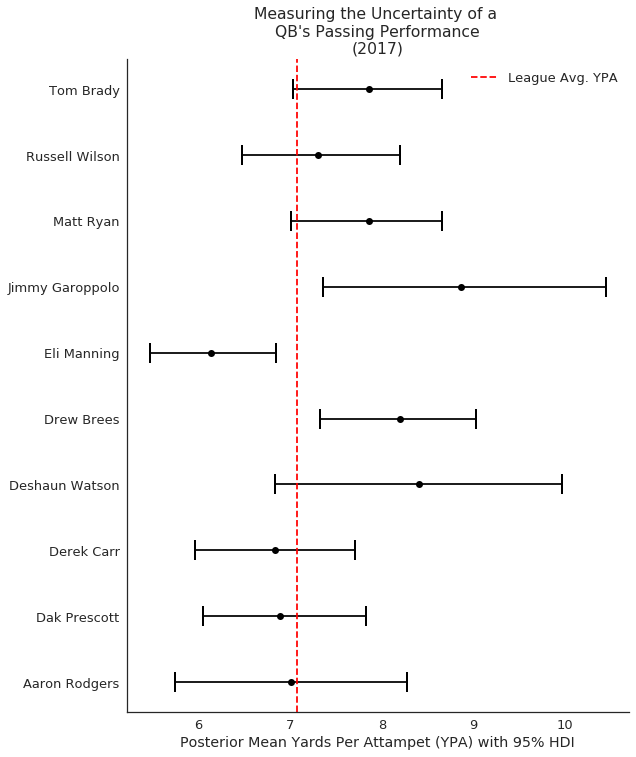

In [28]:
# league average ypa as a comparison point
ypa = qb_pass_df.Yards_Gained.sum() / qb_pass_df.Yards_Gained.size
# in order to plot the HDI as error bars around a player's posterior mean
# we have to do this transformation of the data and pass it to 
# matplotlib's errorbar function parameter xerr
ypa_ci = np.array(list(zip(-ypa_df.lower_ci_diff, 
                            ypa_df.upper_ci_diff))).T

# now create the plot
plt.figure(figsize=(9,12))
plt.errorbar('est_mean_ypa', 'Player', xerr=ypa_ci, data=ypa_df, fmt='ko', 
             capthick=2, capsize=10, label=None)
plt.axvline(ypa, color='r', linestyle='--', label='League Avg. YPA')
plt.xlabel('Posterior Mean Yards Per Attampet (YPA) with 95% HDI')
title = 'Measuring the Uncertainty of a \nQB\'s Passing Performance\n(2017)'
plt.title(title)
plt.legend()
sns.despine();

We can also create ridgeline plots (formerly known as [joyplots](http://serialmentor.com/blog/2017/9/15/goodbye-joyplots)) to plot out the full posterior distribution for each player.

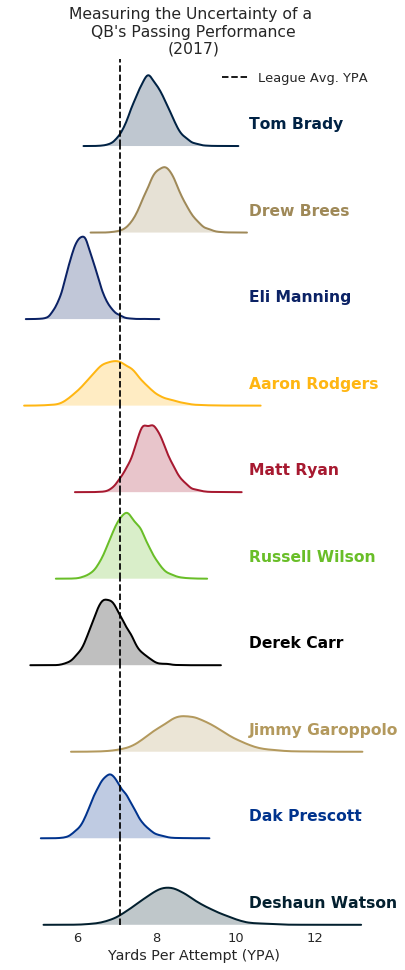

In [29]:
# explode list of psoteriors to make it easier to plot joy plot
# https://stackoverflow.com/questions/42012152/unstack-a-pandas-column-containing-lists-into-multiple-rows
ypa_posterior_df = pd.DataFrame({'Player': np.repeat(ypa_df.Player, 
                                                     ypa_df.posterior.str.len()),
                                 'posterior': np.concatenate(ypa_df.posterior.values)})

# this code is based on the code from the seaborn documentation
# https://seaborn.pydata.org/examples/kde_joyplot.html
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.65, .2, label, fontweight="bold", color=color, 
            transform=ax.transAxes)

# use team colors for each player
tm_colors = ['#002244', '#9F8958', '#0B2265', '#FFB612', '#A71930', 
             '#69BE28', '#000000', '#B3995D', '#00338D', '#03202F']

# initialize the FacetGrid object
g = sns.FacetGrid(ypa_posterior_df, row="Player", hue="Player", aspect=4.5, 
                  size=1.3, palette=tm_colors)
# plot each player's posterior distribution
g.map(sns.kdeplot, "posterior", clip_on=False, shade=True, lw=2)
# label each distribution with the player's name
g.map(label, "posterior")
# add the the line representing the league avg YPA
g.map(plt.axvline, x=ypa, color='k', linestyle='--')
# Adjust the spacing for each player's kde plot so that they are veritcally 
# adjacent to one another
g.fig.subplots_adjust(hspace=0)
# # Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
# add legend, title and xlable
ax1 = g.axes[0, 0]
ax1.legend([ax1.lines[1]], ['League Avg. YPA'])
ax1.set_title(title)
plt.xlabel('Yards Per Attempt (YPA)');

Hopefully you found this blog post helpful.  If you see any mistakes, have any questions or suggestions  [or if you're hiring :)] you can email me at savvas.tjortjoglou@gmail.com, hit me up on Twitter [@savvastj](https://twitter.com/savvastj), or just leave a comment below.

If you like this post and want to support my blog you can check out my patreon page [here](https://www.patreon.com/savvastj).


## Resources

For a deeper dive into the Bayesian bootstrap I suggest reading Rasmus Bååth's series of blog posts on the topic. His conference talk is also worth watching. It’s only 15 minutes and he does a good job explaining both the classical bootstrap and the Bayesian bootstrap.

His blog posts:
- [The Non-parametric Bootstrap as a Bayesian Model](http://sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/)
- [Easy Bayesian Bootstrap in R](http://www.sumsar.net/blog/2015/07/easy-bayesian-bootstrap-in-r/)
- [bayesboot: An R package for doing the Bayesian bootstrap](http://www.sumsar.net/blog/2016/02/bayesboot-an-r-package/)

The video of his talk:
- [bayesboot: An R package for easy Bayesian bootstrapping](https://www.youtube.com/watch?v=VceFc5hsMw8&t=)

Here are links to github repositories for the R package `bayesboot` and the Python package `bayesian_bootstrap':
- [bayesboot](https://github.com/rasmusab/bayesboot)
- [bayesian_bootstrap](https://github.com/lmc2179/bayesian_bootstrap)

You can find the notebook and the data used for this post on [github](https://github.com/savvastj/nfl_bayesian_bootstrap).